* lightGBM Kfold 예제
http://machinelearningkorea.com/2019/08/04/lightgbm-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9Dcross-validation-%EC%B9%98%ED%8A%B8%EC%BD%94%EB%93%9C/

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

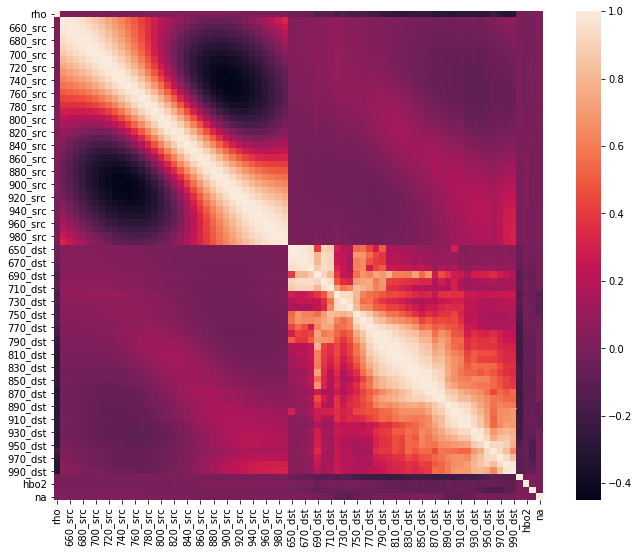

In [4]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def df_preview(df):
    for col in df.columns:
        print(col, "null count ::", df[col].isnull().sum(), "// mean ::", df[col].mean())

def df_col_distplot(df):
    for col in df.columns:
        print(col, "plot")
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

In [6]:
concat_df = pd.concat([train, test])
concat_df.shape

(20000, 75)

In [7]:
concat_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
id,,,,,,,,,,,,,,,,,,,,,
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12,NaN,NaN,NaN,NaN
19996,25,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,4.514449e-18,NaN,9.128300e-19,NaN,3.928314e-18,2.586781e-17,NaN,NaN,NaN,NaN
19997,15,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,7.789652e-15,NaN,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13,NaN,NaN,NaN,NaN


In [9]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']
feature_df = concat_df.drop(target_cols, axis=1)
feature_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
id,,,,,,,,,,,,,,,,,,,,,
0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17
1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN
2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN
3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN
4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.889599e-13,NaN,4.903209e-13,1.365078e-12,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12
19996,25,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,1.240848e-17,6.258180e-18,8.693704e-20,NaN,4.514449e-18,NaN,9.128300e-19,NaN,3.928314e-18,2.586781e-17
19997,15,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,0.000000e+00,NaN,0.000000e+00,2.610282e-14,7.789652e-15,NaN,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13


In [27]:
## KNNImputer 를 사용함
## n_neighbors = 2

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [12]:
imputed_df = imputer.fit_transform(feature_df)
imputed_df

array([[2.50000000e+01, 3.79500000e-01, 4.29930000e-01, ...,
        1.06750432e-18, 5.99894896e-18, 4.37851307e-17],
       [1.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.01782695e-10, 9.71009101e-09, 1.48240006e-09],
       [2.50000000e+01, 0.00000000e+00, 3.28900000e-02, ...,
        0.00000000e+00, 1.32972481e-18, 1.90921298e-18],
       ...,
       [1.50000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
        1.43661721e-15, 0.00000000e+00, 1.74375146e-13],
       [2.00000000e+01, 8.39000000e-02, 5.69000000e-02, ...,
        4.48919422e-18, 2.89298641e-17, 2.54068668e-16],
       [1.50000000e+01, 1.10160000e-01, 1.15050000e-01, ...,
        1.15264098e-13, 5.59411967e-13, 1.76344575e-12]])

In [13]:
imputed_df.shape

(20000, 71)

In [15]:
## impute 결과가 list 로 나오기 때문에 dataframe 으로 바꿔주는 작업

imputed_df = pd.DataFrame(imputed_df, columns=feature_df.columns, index=list(feature_df.index.values))
imputed_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,2.902866e-19,3.527371e-18,1.933918e-18,6.455564e-19,1.007089e-18,0.000000e+00,3.821327e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,2.097907e-10,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,1.017827e-10,9.710091e-09,1.482400e-09
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.909213e-18
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,7.085245e-11,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,3.070868e-11,4.088921e-10,1.836648e-10
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,2.474000e-12,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.464461e-12,1.330237e-13,1.231381e-11,6.670449e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15.0,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.889599e-13,1.265173e-13,4.903209e-13,1.365078e-12,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12
19996,25.0,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,1.240848e-17,6.258180e-18,8.693704e-20,2.397496e-20,4.514449e-18,1.966065e-18,9.128300e-19,4.692795e-22,3.928314e-18,2.586781e-17
19997,15.0,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,0.000000e+00,5.931498e-13,0.000000e+00,2.610282e-14,7.789652e-15,1.807018e-14,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13
19998,20.0,0.08390,0.05690,0.08343,0.12324,0.12720,0.16732,0.18149,0.23766,0.31407,...,0.000000e+00,7.084232e-18,6.193590e-17,0.000000e+00,2.669004e-18,8.586549e-18,0.000000e+00,4.489194e-18,2.892986e-17,2.540687e-16


In [17]:
target_cols = ['hhb', 'hbo2', 'ca', 'na']
feature_df = concat_df.drop(target_cols, axis=1)
for col in target_cols:
    imputed_df[col] = concat_df[col]

imputed_df

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,1.007089e-18,0.000000e+00,3.821327e-19,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,1.017827e-10,9.710091e-09,1.482400e-09,0.00,2.83,7.25,4.64
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,1.909213e-18,10.64,3.00,8.40,5.16
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,2.245998e-10,1.299511e-10,7.782625e-11,3.070868e-11,4.088921e-10,1.836648e-10,5.67,4.01,5.05,4.35
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,1.457955e-13,8.769053e-14,1.464461e-12,1.330237e-13,1.231381e-11,6.670449e-11,11.97,4.41,10.78,2.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,15.0,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,0.08833,...,7.929664e-13,0.000000e+00,0.000000e+00,1.472213e-13,1.479745e-12,5.391520e-12,NaN,NaN,NaN,NaN
19996,25.0,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,0.24377,...,4.514449e-18,1.966065e-18,9.128300e-19,4.692795e-22,3.928314e-18,2.586781e-17,NaN,NaN,NaN,NaN
19997,15.0,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,1.01179,...,7.789652e-15,1.807018e-14,1.271388e-15,1.436617e-15,0.000000e+00,1.743751e-13,NaN,NaN,NaN,NaN
19998,20.0,0.08390,0.05690,0.08343,0.12324,0.12720,0.16732,0.18149,0.23766,0.31407,...,2.669004e-18,8.586549e-18,0.000000e+00,4.489194e-18,2.892986e-17,2.540687e-16,NaN,NaN,NaN,NaN


In [18]:
imputed_train = imputed_df[imputed_df['hhb'].notnull()]
imputed_test = imputed_df[imputed_df['hhb'].isnull()]

In [24]:
## KNN impute 사용 lightgbm 사용
## submission 제출 결과 : 1.32443

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

feature_col = imputed_df.columns.drop(['hhb', 'hbo2', 'ca', 'na'])
target_col_list = ['hhb', 'hbo2', 'ca', 'na']

for target_col in target_col_list:
    x_data = imputed_train[feature_col]
    y_data = imputed_train[target_col]
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)

    lgbmr = LGBMRegressor(objective='regression', num_iterations=10**3, n_estimators= 2000)
    lgbmr.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)

    # print(y_val)
    # print(type(y_val))
    # print(y_val.index)

    val_pred = lgbmr.predict(x_val)
    val_pred = pd.DataFrame(val_pred, columns=[target_col], index=list(y_val.index))
    score = rmse(val_pred, y_val)
    print(target_col,'::',score)

    test_x = imputed_test[feature_col]
    test_pred = lgbmr.predict(test_x)
    submission[target_col] = test_pred

hhb :: 1.4732558007797003
hbo2 :: 0.8509887044633767
ca :: 2.5460571057923174
na :: 1.765845039642335


In [26]:
import time
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)

In [30]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 5, shuffle = True, random_state = 551)

In [58]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission

,hhb,hbo2,ca,na
id,,,,
10000,0,0,0,0
10001,0,0,0,0
10002,0,0,0,0
10003,0,0,0,0
10004,0,0,0,0
...,...,...,...,...
19995,0,0,0,0
19996,0,0,0,0
19997,0,0,0,0


In [59]:
## kfold 교차검증
## kfold 로 5개를 만들어서 lgbm 으로 학습 후 
## 에측한 값들의 합을 5로 나눈값으로 제출함

## 결과값 1.29401	

import lightgbm as lgb

feature_col = imputed_df.columns.drop(['hhb', 'hbo2', 'ca', 'na'])
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

for target_col in target_col_list:
    print("target_col :: ",target_col)
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(imputed_train)):
        x_data = imputed_train[feature_col]
        y_data = imputed_train[target_col]

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        train_ds = lgb.Dataset(train_X, label=train_y)
        valid_ds = lgb.Dataset(valid_X, label=valid_y)

        params = {
            'objective':'regression', 
            'num_iterations':10**3, 
            'n_estimators': 2000,
            'metric': 'rmse',
        }

        model = lgb.train(
            params=params, 
            train_set=train_ds, 
            valid_sets=valid_ds, 
            verbose_eval=2000, 
            early_stopping_rounds=100 
        )

        test_x = imputed_test[feature_col]
        test_pred = model.predict(test_x)
        submission[target_col] = submission[target_col] + test_pred

target_col ::  hhb
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	valid_0's rmse: 1.49102
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[519]	valid_0's rmse: 1.47497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	valid_0's rmse: 1.52508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's rmse: 1.45682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's rmse: 1.53141
target_col ::  hbo2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's rmse: 0.858308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[317]	valid_0's rmse: 0.867939
Training until validation scores don't improve for 100 rounds
Early st

In [61]:
submission = submission / 5
submission

,hhb,hbo2,ca,na
id,,,,
10000,8.163652,4.281865,9.413145,3.569827
10001,6.689202,3.328703,7.517165,3.095974
10002,10.425372,4.789654,10.487744,3.502697
10003,9.146335,4.148778,10.627393,2.979493
10004,6.163092,3.885118,8.639215,4.023038
...,...,...,...,...
19995,4.641140,3.821082,11.407485,3.651008
19996,10.666168,3.441577,8.523298,2.762382
19997,8.333347,3.737722,8.289599,3.402703


In [62]:
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)

In [70]:
import lightgbm as lgb

feature_col = imputed_df.columns.drop(['hhb', 'hbo2', 'ca', 'na'])
target_col_list = ['hhb', 'hbo2', 'ca', 'na']
# target_col_list = ['hhb']
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')


for target_col in target_col_list:
    print("target_col :: ",target_col)
    x_data = imputed_train[feature_col]
    y_data = imputed_train[target_col]

    dummy_df_train = pd.DataFrame(index=list(imputed_train.index.values))
    dummy_df_test = pd.DataFrame(index=list(imputed_test.index.values))

    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(imputed_train)):

        train_X, train_y = x_data.iloc[trn_idx], y_data.iloc[trn_idx] 
        valid_X, valid_y = x_data.iloc[val_idx], y_data.iloc[val_idx]

        train_ds = lgb.Dataset(train_X, label=train_y)
        valid_ds = lgb.Dataset(valid_X, label=valid_y)

        params = {
            'objective':'regression', 
            'num_iterations':10**3, 
            'n_estimators': 2000,
            'metric': 'rmse',
        }

        model = lgb.train(
            params=params, 
            train_set=train_ds, 
            valid_sets=valid_ds, 
            verbose_eval=False, 
            early_stopping_rounds=100 
        )

        ## stacking train/test 준비
        
        stack_pred_train = model.predict(x_data)
        stack_pred_test = model.predict(imputed_test[feature_col])
        dummy_df_train[target_col + "_" + str(n_fold)] = stack_pred_train
        dummy_df_test[target_col + "_" + str(n_fold)] = stack_pred_test

        stack_x = dummy_df_train
        stack_y = y_data

        stack_x_train, stack_x_val, stack_y_train, stack_y_val = train_test_split(stack_x, stack_y, random_state=0)

        ## stacking 훈련

        lgbmr = LGBMRegressor(objective='regression', num_iterations=10**3, n_estimators= 2000)
        lgbmr.fit(stack_x_train, stack_y_train, eval_set=[(stack_x_val, stack_y_val)], early_stopping_rounds=100, verbose=False)

        ## train 으로 훈련한 모델로 test stack 데이터를 예측함


        pred = lgbmr.predict(dummy_df_test)
        submission[target_col] = pred

        # submission[target_col] = submission[target_col] + test_pred


target_col ::  hhb
target_col ::  hbo2
target_col ::  ca
target_col ::  na


In [71]:
submission

,hhb,hbo2,ca,na
id,,,,
10000,9.009402,4.490610,9.429857,3.984494
10001,6.866782,3.313255,7.511199,2.473681
10002,10.376692,5.032532,10.472825,3.378359
10003,9.295890,4.449846,10.009187,3.187134
10004,5.833253,3.872567,8.258121,6.886450
...,...,...,...,...
19995,4.825525,3.948263,12.654094,4.137150
19996,10.890174,3.678691,7.934538,2.568393
19997,7.697023,3.618555,9.475711,3.446795


In [72]:
filename = time.strftime('%Y-%m-%d-%H_%M_%S')+'submission.csv'
submission.to_csv(filename, index=True)